In [1]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
from pmdarima.arima import CHTest, nsdiffs
from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline

import os

import random

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
path = "/Users/williamearley/Quarter 5/Capstone/Data"

In [4]:
df_train = pd.read_csv(os.path.join(path, 'train.csv'))
df_transaction = pd.read_csv(os.path.join(path, 'transactions.csv'))
df_holidays = pd.read_csv(os.path.join(path, 'holidays_events.csv'))
df_oil = pd.read_csv(os.path.join(path, 'oil.csv'))
df_stores = pd.read_csv(os.path.join(path, 'stores.csv'))
df_test = pd.read_csv(os.path.join(path, 'test.csv'))

In [5]:
dtypes = {'id': 'int64', 'store_nbr':'int8', 'onpromotion': str}

# Data Cleaning

In [10]:
# Just renaming the price column of the oil df

new_oil = df_oil.copy()

new_oil.rename(columns={'dcoilwtico': 'price'}, inplace=True)

# Data Merging

In [12]:
# Here we write a function that checks the matching columns across all datasets

# Need a class to assign names to the datasets
class NamedDataFrame(pd.DataFrame):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = name
        
# Function to output the matching pairs
def matching_pairs(df:list):
    for df1_idx, (df1, df1_name) in enumerate(df):
        for df2_idx, (df2, df2_name) in enumerate(df):
            if df1_idx < df2_idx:
                common_columns = [i for i in df1.columns if any(i in j for j in df2.columns)]
                
                print(f"Matching columns between {df1_name} and {df2_name}: {common_columns}")

In [13]:
# name the datasets
datasets = [
    (df_oil, 'Oil'),
    (df_holidays, 'Holidays'),
    (df_stores, 'Stores'),
    (df_transaction, 'Transactions'),
    (df_train, 'Train'),
    (df_test, 'Test')
]

In [14]:
# Use our function to check pairs
matching_pairs(datasets)

Matching columns between Oil and Holidays: ['date']
Matching columns between Oil and Stores: []
Matching columns between Oil and Transactions: ['date']
Matching columns between Oil and Train: ['date']
Matching columns between Oil and Test: ['date']
Matching columns between Holidays and Stores: ['type']
Matching columns between Holidays and Transactions: ['date']
Matching columns between Holidays and Train: ['date']
Matching columns between Holidays and Test: ['date']
Matching columns between Stores and Transactions: ['store_nbr']
Matching columns between Stores and Train: ['store_nbr']
Matching columns between Stores and Test: ['store_nbr']
Matching columns between Transactions and Train: ['date', 'store_nbr']
Matching columns between Transactions and Test: ['date', 'store_nbr']
Matching columns between Train and Test: ['id', 'date', 'store_nbr', 'family', 'onpromotion']


In [15]:
# make a function that compares two dates and checks the date range
def date_comparison(date_column1, date_column2):
    """
    Compare two date columns and print counts and date ranges.
    
    Parameters:
    - date_column1: The first date column (as a pandas Series).
    - date_column2: The second date column (as a pandas Series).

    Returns:
    - A dictionary containing the count of common and uncommon dates, as well as date ranges.
    """
    # Convert date columns to sets for faster set operations
    dates1 = set(date_column1)
    dates2 = set(date_column2)

    # Find common dates
    common_dates = dates1.intersection(dates2)
    count_common = len(common_dates)

    # Find uncommon dates
    uncommon_dates = dates1.symmetric_difference(dates2)
    count_uncommon = len(uncommon_dates)

    # Find date range for dates1 dataset
    date_range1 = (min(dates1), max(dates1))

    # Find date range for dates2 dataset
    date_range2 = (min(dates2), max(dates2))

    # Store the counts and date ranges in a dictionary
    results = {
        'Common': count_common,
        'Uncommon': count_uncommon,
        'Date Range 1': date_range1,
        'Date Range 2': date_range2
    }

    return results

In [16]:
# Compare transaction and train
compare_result_train=date_comparison(df_transaction['date'], df_train['date'])

pd.DataFrame(compare_result_train)

Common  Uncommon Date Range 1 Date Range 2
0    1682         2   2013-01-01   2013-01-01
1    1682         2   2017-08-15   2017-08-15

In [17]:
# Compare transaction and test
compare_result_test=date_comparison(df_transaction['date'], df_test['date'])

pd.DataFrame(compare_result_test)

Common  Uncommon Date Range 1 Date Range 2
0       0      1698   2013-01-01   2017-08-16
1       0      1698   2017-08-15   2017-08-31

In [20]:
# Merge oil and train
new_train = df_train.copy()
new_train = pd.merge(df_train, new_oil, on=['date'])

In [21]:
new_train.tail(3)

id        date  store_nbr                      family     sales  \
2143743  3000885  2017-08-15          9                     PRODUCE  2419.729   
2143744  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
2143745  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  price  
2143743          148  47.57  
2143744            8  47.57  
2143745            0  47.57

In [22]:
# Merge holidays, stores, and transactions to new_train
new_train = pd.merge(new_train, df_holidays, on=["date"])
new_train = pd.merge(new_train, df_stores, on=["store_nbr"])
new_train = pd.merge(new_train, df_transaction, on=["date", 'store_nbr'])

In [23]:
# Doing some renaming
new_train.rename(columns={'type_x':'holiday_type', 'type_y': 'store_type'}, inplace=True)

In [30]:
# it will be helpful later if we have the date features in different amounts. Year, year-month, month and day

new_train['year'] = new_train.date.dt.year

new_train['year-month'] = new_train['date'].apply(lambda x : x.strftime('%Y-%m'))

new_train['month'] = new_train.date.dt.month

new_train['day'] = new_train.date.dt.day

In [32]:
# See if all months are there
sorted(new_train['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [33]:
# Make date the index
new_train.set_index('date', inplace=True)

In [34]:
# Convert onpromotion to int
new_train['onpromotion'] = new_train['onpromotion'].astype('int')

### Time series Interpolation

In [40]:
oil_price = new_train['price']

In [41]:
oil_price_interpolated = oil_price.interpolate(method='index')

### Data Merging

In [43]:
df_merged = df_train.merge(df_stores, on='store_nbr', how='left')

In [44]:
df_merged = df_merged.merge(df_oil, on='date', how='left')

In [45]:
df_merged = df_merged.merge(df_holidays, on='date', how='left')

In [46]:
# Fill in missing values introduced by merging
df_merged[['type_y', 'locale', 'locale_name']] = df_merged[['type_y', 'locale', 'locale_name']].fillna('NoHoliday')
df_merged['transferred'] = df_merged['transferred'].fillna(False)

In [47]:
df_merged['onpromotion'] = pd.to_numeric(df_merged['onpromotion'], errors='coerce')

In [49]:
# Setting id as index
df_merged.set_index('id', inplace=True)

In [50]:
df_merged.head(3)

date  store_nbr      family  sales  onpromotion   city      state  \
id                                                                            
0   2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   

   type_x  cluster  dcoilwtico   type_y    locale locale_name  \
id                                                              
0       D       13         NaN  Holiday  National     Ecuador   
1       D       13         NaN  Holiday  National     Ecuador   
2       D       13         NaN  Holiday  National     Ecuador   

           description  transferred  
id                                   
0   Primer dia del ano        False  
1   Primer dia del ano        False  
2   Primer dia del ano        False

In [51]:
# Columns we don't need so we can drop
cols_drop = ['city', 'state', 'type_x', 'dcoilwtico', 'type_y', 'locale', 'locale_name', 'transferred']

# Drop the columns
df_merged = df_merged.drop(columns=cols_drop)

In [52]:
# Put sales last
cols = [col for col in df_merged.columns if col != 'sales'] + ['sales']
df_merged = df_merged[cols]

In [53]:
df_merged.head(3)

date  store_nbr      family  onpromotion  cluster  \
id                                                            
0   2013-01-01          1  AUTOMOTIVE            0       13   
1   2013-01-01          1   BABY CARE            0       13   
2   2013-01-01          1      BEAUTY            0       13   

           description  sales  
id                             
0   Primer dia del ano    0.0  
1   Primer dia del ano    0.0  
2   Primer dia del ano    0.0

In [54]:
# Aggregating data
df_family_aggregated = df_merged.groupby(['date', 'family', 'store_nbr']).agg({'sales': 'sum', 'onpromotion': 'sum' }).reset_index()

In [55]:
df_family_aggregated.shape

(3000888, 5)

### Feature Engineering

In [57]:
df_family_aggregated['date'] = pd.to_datetime(df_family_aggregated['date'])

In [58]:
# Create day of week feature
df_family_aggregated['day_of_week'] = df_family_aggregated['date'].dt.dayofweek

# Lag sales by 1 to get previous day of sales value
df_family_aggregated['lag_1'] = df_family_aggregated['sales'].shift(1)

# Add rolling mean for 7-day window
df_family_aggregated['rolling_mean'] = df_family_aggregated['sales'].rolling(window=7).mean()

In [59]:
# Drop the missing values
df_family_aggregated.dropna(inplace=True)

In [60]:
# Find shape
df_family_aggregated.shape

(3000882, 8)

# Feature Encoding

In [61]:
# One-hot encoding for family column
df_family_dummies = pd.get_dummies(df_family_aggregated['family'], drop_first=True, prefix='family')

In [63]:
# One-hot encoding for family column
df_family_aggregated = pd.concat([df_family_aggregated, df_family_dummies], axis=1)

# No need for family column anymore
df_family_aggregated.drop('family', axis=1, inplace=True)

### Feature Scaling

In [64]:
# These columns need to be scaled
columns_to_scale = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean', 'sales'] + list(df_family_dummies.columns)

# Introduce MinMaxScaler
scaler = MinMaxScaler()

# Apply
df_family_aggregated[columns_to_scale] = scaler.fit_transform(df_family_aggregated[columns_to_scale])

In [65]:
# Sort by date
df_family_aggregated = df_family_aggregated.sort_values('date')

In [104]:
df_family_aggregated.shape

(3000882, 39)

### Train Test Split

In [67]:
train_size = int(0.8 * len(df_family_aggregated))
train_data = df_family_aggregated[:train_size]
test_data = df_family_aggregated[train_size:]

In [68]:
train_data.shape, test_data.shape

((2400705, 39), (600177, 39))

In [69]:
# Set up training set
X_train = train_data.drop(columns=['sales', 'date'])
y_train = train_data['sales']

In [70]:
# Set up test set
X_test = test_data.drop(columns=['sales', 'date'])
y_test = test_data['sales']

### Modeling

In [71]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [72]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

In [73]:
# Exogenous variables to help predict sales
ex_variables = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']

In [74]:
X_train.shape

(2400705, 37)

## XGBOOST Regressor Model

In [75]:
# Define xgboost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Fit model
model_xgb.fit(X_train, y_train)

# Predict
forecast_xgb = model_xgb.predict(X_test)

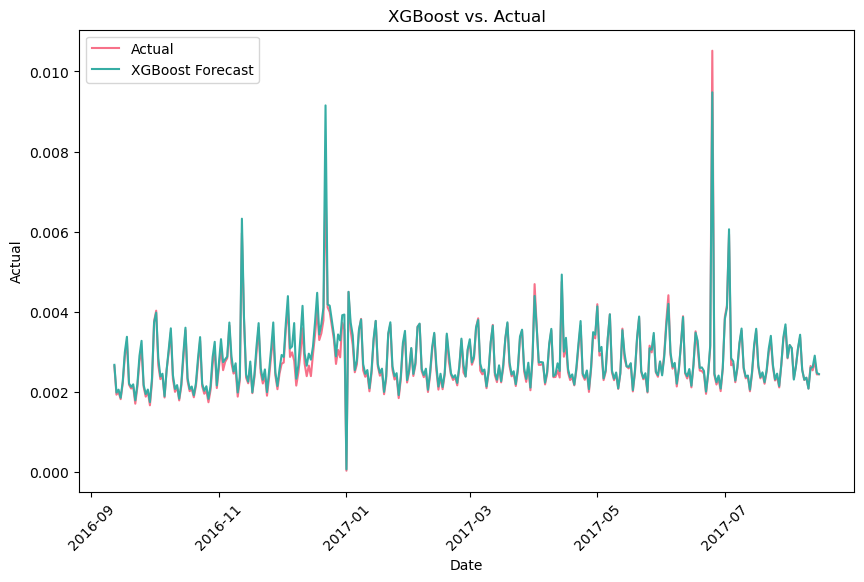

In [76]:
# Plot predictions
plot_predictions(test_data['date'], y_test, forecast_xgb, 'XGBoost Forecast', 'XGBoost vs. Actual')

In [77]:
# Metrics 
xgboost_metrics = evaluate_forecast(y_test, forecast_xgb)

xgboost_metrics

{'MSE': 6.328852875873353e-06,
 'RMSE': 0.002515721144299056,
 'RMSLE': 0.002333121059291799}

## Hyperparameter Tuning

Going to be implementing a randomized search to fine-tune our XGBoost model. 

In [127]:
xgb_param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6]
}

# Instance of model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Perform search
random_search = RandomizedSearchCV(
    model_xgb,
    param_distributions = xgb_param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)

In [91]:
# Make a prediction with the best model
forecast_xgb_best = best_xgb_model.predict(X_test)

In [92]:
# Calculate evaluation metrics
xgb_best = evaluate_forecast(y_test, forecast_xgb_best)

xgb_best

{'MSE': 0.00031616243284885175,
 'RMSE': 0.01778095702848561,
 'RMSLE': 0.011742838368941242}

### Trying to make future predictions on actual kaggle supplied test set

In [78]:
df_test.head(3)

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2

Need to start by doing the same pre processing steps

In [79]:
test_aggregated = df_test.copy()

In [80]:
test_aggregated['date'] = pd.to_datetime(test_aggregated['date'])

In [81]:
test_aggregated.head(5)

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [82]:
# Get the day of the week feature and add it
test_aggregated['day_of_week'] = test_aggregated['date'].dt.dayofweek

In [83]:
# The lag cannot be computed here because there is no previous data
test_aggregated['lag_1'] = 0

# Same applies to the rolling mean
test_aggregated['rolling_mean'] = 0

In [84]:
# Apply the preprocessing steps done with the train on the test too
df_test_dummies = pd.get_dummies(test_aggregated['family'], drop_first=True, prefix='family')

# Apply to concatenate the dummies
test_aggregated = pd.concat([test_aggregated, df_test_dummies], axis=1)

# Drop the family column as it has already been processed
test_aggregated.drop('family', axis=1, inplace=True)

In [85]:
#  Apply the scaling
columns_to_scale_test = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean'] + list(df_test_dummies.columns)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(df_family_aggregated[columns_to_scale_test])

# Now, use this new scaler to transform the test set
test_aggregated[columns_to_scale_test] = min_max_scaler.transform(test_aggregated[columns_to_scale_test])

# Sort the values by date
test_aggregated = test_aggregated.sort_values('date')

In [86]:
test_aggregated.head(3)

id       date  store_nbr  onpromotion  day_of_week  lag_1  \
0     3000888 2017-08-16          1          0.0          2.0    0.0   
1194  3002082 2017-08-16         42          0.0          2.0    0.0   
1193  3002081 2017-08-16         42         12.0          2.0    0.0   

      rolling_mean  family_BABY CARE  family_BEAUTY  family_BEVERAGES  ...  \
0              0.0               0.0            0.0               0.0  ...   
1194           0.0               0.0            0.0               0.0  ...   
1193           0.0               0.0            0.0               0.0  ...   

      family_MAGAZINES  family_MEATS  family_PERSONAL CARE  \
0                  0.0           0.0                   0.0   
1194               0.0           0.0                   0.0   
1193               0.0           0.0                   0.0   

      family_PET SUPPLIES  family_PLAYERS AND ELECTRONICS  family_POULTRY  \
0                     0.0                             0.0             0.0   
1194                  0.0                             0.0             0.0   
1193                  0.0                             0.0             0.0   

      family_PREPARED FOODS  family_PRODUCE  \
0                       0.0             0.0   
1194                    0.0             0.0   
1193                    0.0             0.0   

      family_SCHOOL AND OFFICE SUPPLIES  family_SEAFOOD  
0                                   0.0             0.0  
1194                                0.0             0.0  
1193                                0.0             0.0  

[3 rows x 39 columns]

In [87]:
# Features to use to forecast

# X_train features 
X_train_features = X_train.columns.to_list()

# Values to forecast
X_test_to_forecast = test_aggregated[X_train_features]

In [89]:
# Apply the best model to forecast
forecast = model_xgb.predict(X_test_to_forecast)

In [91]:
len(forecast)

28512

In [93]:
test_aggregated['sales'] = forecast

In [95]:
test_aggregated = test_aggregated.sort_values('id')

In [96]:
test_aggregated.head(5)

id       date  store_nbr  onpromotion  day_of_week  lag_1  \
0  3000888 2017-08-16          1          0.0          2.0    0.0   
1  3000889 2017-08-16          1          0.0          2.0    0.0   
2  3000890 2017-08-16          1          2.0          2.0    0.0   
3  3000891 2017-08-16          1         20.0          2.0    0.0   
4  3000892 2017-08-16          1          0.0          2.0    0.0   

   rolling_mean  family_BABY CARE  family_BEAUTY  family_BEVERAGES  ...  \
0           0.0               0.0            0.0               0.0  ...   
1           0.0               1.0            0.0               0.0  ...   
2           0.0               0.0            1.0               0.0  ...   
3           0.0               0.0            0.0               1.0  ...   
4           0.0               0.0            0.0               0.0  ...   

   family_MEATS  family_PERSONAL CARE  family_PET SUPPLIES  \
0           0.0                   0.0                  0.0   
1           0.0                   0.0                  0.0   
2           0.0                   0.0                  0.0   
3           0.0                   0.0                  0.0   
4           0.0                   0.0                  0.0   

   family_PLAYERS AND ELECTRONICS  family_POULTRY  family_PREPARED FOODS  \
0                             0.0             0.0                    0.0   
1                             0.0             0.0                    0.0   
2                             0.0             0.0                    0.0   
3                             0.0             0.0                    0.0   
4                             0.0             0.0                    0.0   

   family_PRODUCE  family_SCHOOL AND OFFICE SUPPLIES  family_SEAFOOD     sales  
0             0.0                                0.0             0.0  0.000042  
1             0.0                                0.0             0.0  0.000042  
2             0.0                                0.0             0.0  0.024473  
3             0.0                                0.0             0.0  0.019052  
4             0.0                                0.0             0.0 -0.000011  

[5 rows x 40 columns]

In [98]:
df_sample_sub = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [101]:
df_sample_sub['sales'] = test_aggregated['sales']

In [102]:
df_sample_sub.head()

id     sales
0  3000888  0.000042
1  3000889  0.000042
2  3000890  0.024473
3  3000891  0.019052
4  3000892 -0.000011

In [103]:
df_sample_sub.to_csv('submission225.csv', index=False)